# Cryptic calculations

Since I'm too scared to buy my own crypto, I thought I'd atleast have a dig at trying to predict the prices for those people that are braver than me.

I'll just focus on bitcoin at the moment, but might extend it out later on.

In [2]:
%matplotlib inline

import pandas as pd
from os.path import join

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, ElasticNetCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, chi2, VarianceThreshold

import xgboost as xgb

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Defining custom formatter

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

rand_seed = 1234

## Evaluation metric

As how we evaluate models is really important, I'm going to keep it simple and use mean absolute error (MAE).
See here for a bit more info:

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [3]:
df = pd.read_csv('../input/crypto-markets.csv', parse_dates = ['date'],
                index_col =['date'])

btc = df.loc[df['symbol'] == "BTC", "close"]

## Exploring the data

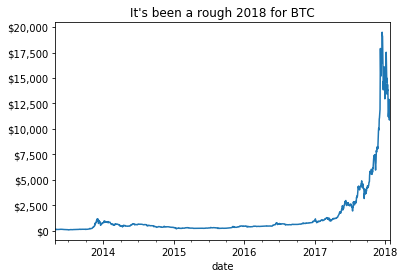

In [4]:
fig, ax = plt.subplots()

btc.plot(ax=ax)
ax.get_yaxis().set_major_formatter(tick)
ax.set(title="It's been a rough 2018 for BTC");

## Feature Engineering

I'm going to keep it quite simple at the moment and just generate a few features:

- Lagged vars
- Rolling means
- Rolling variances

In [6]:
btc = btc.reset_index()

print("BTC has %s rows " % (btc.shape[0]))

print("Creating a few lagged variables..")

btc['lag_1'] =  btc['close'].shift()
btc['lag_2'] =  btc['close'].shift(2)
btc['lag_3'] =  btc['close'].shift(3)
btc['lag_4'] =  btc['close'].shift(4)
btc['lag_5'] =  btc['close'].shift(5)

print("Creating some rolling window variables")

print("Means..")

btc['roll_mean_5'] = btc['close'].rolling(5).mean()
btc['roll_mean_7'] = btc['close'].rolling(7).mean()
btc['roll_mean_14'] = btc['close'].rolling(14).mean()
btc['roll_mean_30'] = btc['close'].rolling(30).mean()

print("Variances..")

btc['roll_var_5'] = btc['close'].rolling(5).var()
btc['roll_var_7'] = btc['close'].rolling(7).var()
btc['roll_var_14'] = btc['close'].rolling(14).var()
btc['roll_var_30'] = btc['close'].rolling(30).var()

print(btc.head())

BTC has 1736 rows 
Creating a few lagged variables..
Creating some rolling window variables
Means..
Variances..
   index       date   close   lag_1   lag_2   lag_3   lag_4  lag_5  \
0      0 2013-04-28  134.21     NaN     NaN     NaN     NaN    NaN   
1      1 2013-04-29  144.54  134.21     NaN     NaN     NaN    NaN   
2      2 2013-04-30  139.00  144.54  134.21     NaN     NaN    NaN   
3      3 2013-05-01  116.99  139.00  144.54  134.21     NaN    NaN   
4      4 2013-05-02  105.21  116.99  139.00  144.54  134.21    NaN   

   roll_mean_5  roll_mean_7  roll_mean_14  roll_mean_30  roll_var_5  \
0          NaN          NaN           NaN           NaN         NaN   
1          NaN          NaN           NaN           NaN         NaN   
2          NaN          NaN           NaN           NaN         NaN   
3          NaN          NaN           NaN           NaN         NaN   
4       127.99          NaN           NaN           NaN   268.43485   

   roll_var_7  roll_var_14  roll_var_30 

## Advanced feature engineering
### EWMA

This is the same general idea as the moving averages calculated before, but the weight of later periods exponentially decays over time.

Hopefully it'll be a good way for the models to pick up on the recent trends, but not get too distracted with events that happened awhile ago.

In [7]:
btc.index = btc['date']

btc['ewma_60'] = btc["close"].ewm(span=60, freq="D").mean()
btc['ewma_30'] = btc["close"].ewm(span=30, freq="D").mean()

## Creating the training / validation split

In [8]:
print("Dropping missing variables..")

btc = btc.dropna()
test_index = btc['date'] >= '2017-11-01'

X = btc.drop(['close', 'date'], axis=1)
y = btc['close']

X_train = X.loc[~test_index, :]
X_test = X.loc[test_index, :]
y_train = y.loc[~test_index].values
y_test = y.loc[test_index].values

Dropping missing variables..


## Building the models / pipelines

In [14]:
print("Building simple models..")

linear = LinearRegression()
bayesRidge = BayesianRidge()
enet = ElasticNetCV(random_state=rand_seed)
rf = RandomForestRegressor(n_estimators=500, random_state=rand_seed)
xgReg = xgb.XGBRegressor(seed=rand_seed)

print("Building pipelines..")

linear_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(linear)),
    ('reg', linear)
])

bayes_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(bayesRidge)),
    ('reg', bayesRidge)
])

enet_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(enet)),
    ('reg', enet)
])

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(rf)),
    ('reg', rf)
])

xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('reg', xgReg)
])

Building simple models..
Building pipelines..


### Testing out the simple models

In [10]:
models = [linear, bayesRidge, enet, rf, xgReg]
model_dict = {0: "Linear regression", 1: "Bayesian Ridge", 2: "Elastic Net CV", 
              3: "Random Forest", 4: "Xgboost regression"}

model_res = []
res_dict = {}

for i, model in enumerate(models):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    res_dict[i] = preds
    
    mae_res = mean_absolute_error(y_test, preds)
    
    print("MAE for %s =%s" % (model_dict[i], mae_res))
    model_res.append(mae_res)
    
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= y_test,
                      date_range = pd.date_range('2017-11-01', '2018-01-27', freq ="D"))
              .set_index("date_range"))    

MAE for Linear regression =3.41143194501e-10
MAE for Bayesian Ridge =8.28218947969e-08
MAE for Elastic Net CV =17731.6979783
MAE for Random Forest =5909.01350886
MAE for Xgboost regression =6201.25684482


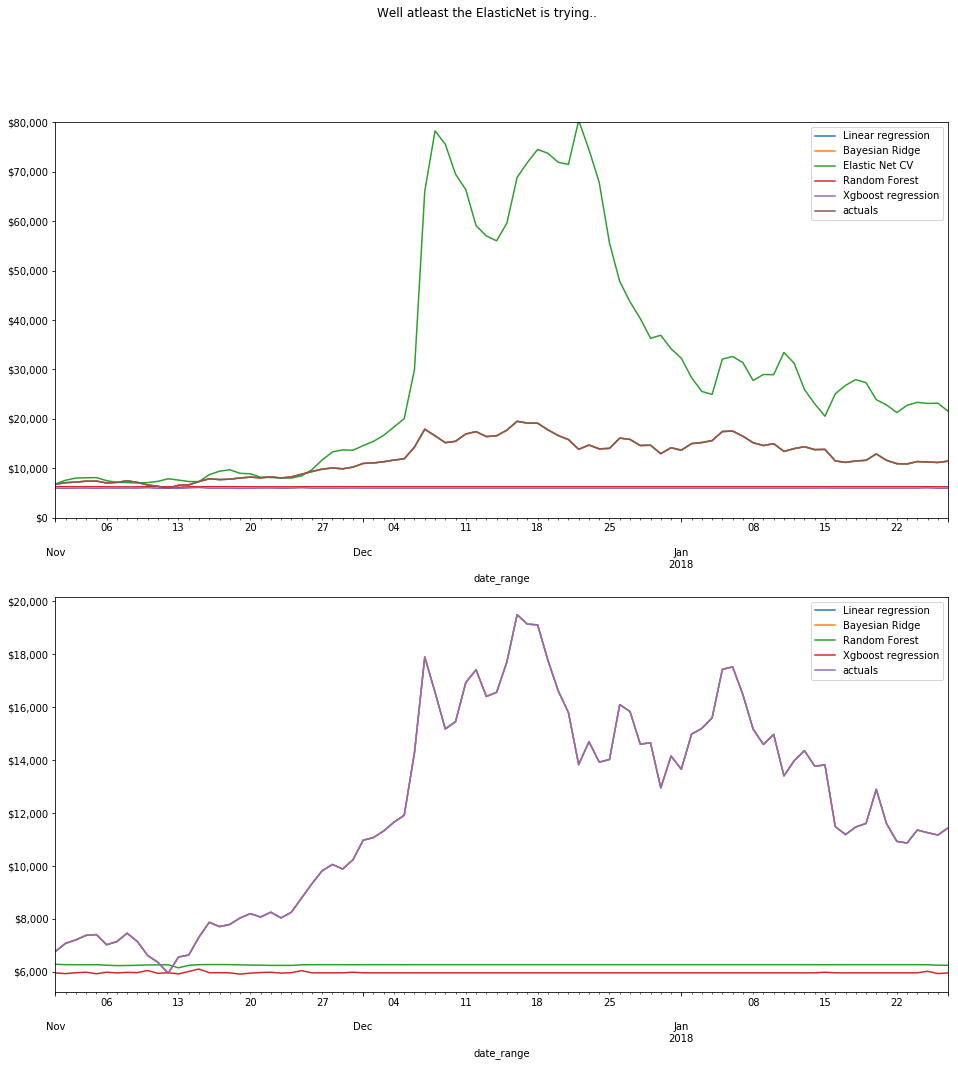

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, figsize=(16, 16))

res_df.plot(ax=ax0)
ax0.get_yaxis().set_major_formatter(tick)
ax0.set_ylim(0, 80000)

res_df.drop("Elastic Net CV", axis=1).plot(ax=ax1)

ax1.get_yaxis().set_major_formatter(tick)
fig.suptitle("Well atleast the ElasticNet is trying..");

## Testing out the pipelines

In [12]:
models = [linear_pipe, bayes_pipe, enet_pipe, rf_pipe, xgb_pipe]

model_dict = {0: "Linear regression pipe", 1: "Bayesian Ridge pipe", 2: "Elastic Net CV pipe", 
              3: "Random Forest pipe", 4: "Xgboost regression pipe"}

model_res = []
res_dict = {}

for i, model in enumerate(models):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    res_dict[i] = preds
    
    mae_res = mean_absolute_error(y_test, preds)
    
    print("MAE for %s =%s" % (model_dict[i], mae_res))
    model_res.append(mae_res)
    
res_df = (pd.DataFrame(data=res_dict)
              .rename(columns=model_dict)
              .assign(actuals= y_test,
                      date_range = pd.date_range('2017-11-01', '2018-01-27', freq ="D"))
              .set_index("date_range"))    

MAE for Linear regression pipe =2.03602791192e-11
MAE for Bayesian Ridge pipe =1.40139697826e-09
MAE for Elastic Net CV pipe =1420.98125335
MAE for Random Forest pipe =5895.46683955
MAE for Xgboost regression pipe =6201.25684482


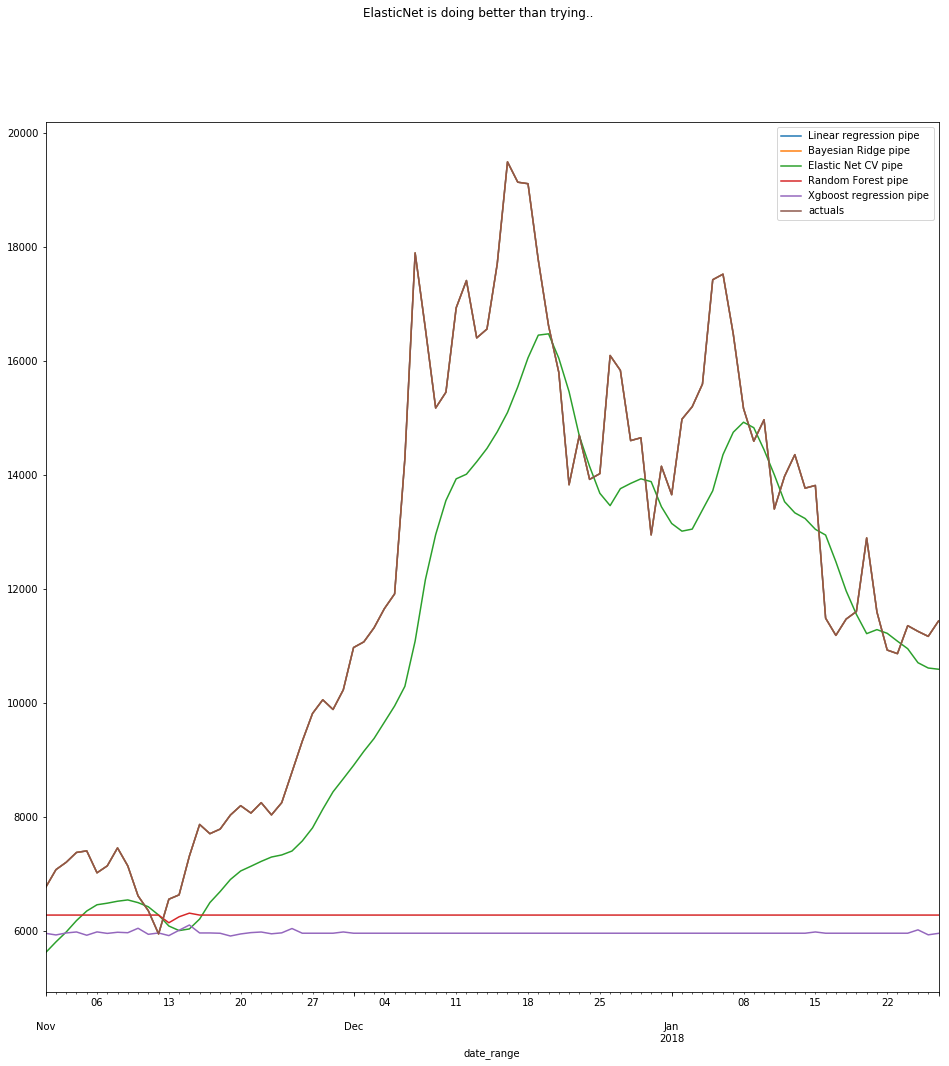

In [16]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16, 16))

res_df.plot(ax=ax)
ax0.get_yaxis().set_major_formatter(tick)
ax0.set_ylim(0, 80000)
fig.suptitle("ElasticNet is doing better than trying..");

Woooo. It looks like the Elastic net with some feature selection seems to be working pretty nicely.

Next I'm going to see if I can boost it's power even more with some additional pipeline steps.

In [ ]:
# TODO:

# 1. Use timeSeriesSplitter to pick hyper-params of best model
# Try and get more outta xgboost etc